In [2]:
%matplotlib inline

In [3]:
%run notebook_setup

theano version: 1.0.4
pymc3 version: 3.7
exoplanet version: 0.2.1


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astropy.time import Time
from astropy.io import ascii
from astropy import units as u
from astropy import constants
import astropy

deg = np.pi/180. # radians / degree
yr = 365.25 # days / year

au_to_R_sun = (constants.au / constants.R_sun).value # conversion constant

In [5]:
# calculate posteriors on MA using the disk samples 
flatchain = np.load("../joint/run10/flatchain.npy")
mass_samples = flatchain[:, 0]
MA_mean = np.mean(mass_samples)
MA_std = np.std(mass_samples)
print(f"{MA_mean:.2f} +/- {MA_std:.2f}")

0.53 +/- 0.01


In [6]:
def get_arrays(asciiTable, errDict=None, jitter=False):
    """
    Reformat ascii tables into pure numpy arrays of the right dimension.
    """
    
    output = []
    
    for star in ["Aa", "Ab"]:
    
        # get the RVs 
        rv = asciiTable["RV_" + star]
        
        if type(rv) is astropy.table.column.MaskedColumn:
            mask = ~rv.mask # values we want to keep when indexing
        else:
            mask = np.ones(len(rv), dtype="bool")

        rv = np.ascontiguousarray(rv[mask])
        date = np.ascontiguousarray(asciiTable["HJD"][mask])
        
        if errDict is None:
            err = np.ascontiguousarray(asciiTable["sigma_" + star][mask])
        else:
            err = np.ones(len(date), dtype=np.float64) * errDict[star]
            
        if jitter:
            err = np.ones(len(date), dtype=np.float64) * 0.1 # [km/s] assume a small error, since we'll infer.

        assert len(date) == len(rv), "date - rv length mismatch"
        assert len(date) == len(err), "date - err length mismatch"
            
        tup = (date, rv, err)

        output.append(tup)

    return output
    
    
# Do this to infer w/ jitter 
jitter=True

# load all the data
data_cfa = ascii.read("data/cfa.dat")
# cfa errors are provided in table 
cfa1,cfa2 = get_arrays(data_cfa, jitter=jitter)

data_keck = ascii.read("data/keck.dat", format="tab", fill_values=[("X", 0)])
err_keck = {"Aa":0.63, "Ab":0.85, "B":0.59} # km/s
keck1,keck2 = get_arrays(data_keck, err_keck, jitter=jitter)

data_feros = ascii.read("data/feros.dat")
err_feros = {"Aa":2.61, "Ab":3.59, "B":2.60} # km/s
feros1,feros2 = get_arrays(data_feros, err_feros, jitter=jitter)

data_dupont = ascii.read("data/dupont.dat", fill_values=[("X", 0)])
err_dupont = {"Aa":1.46, "Ab":2.34, "B":3.95} # km/s
dupont1,dupont2 = get_arrays(data_dupont, err_dupont, jitter=jitter)

data = [data_cfa, data_keck, data_feros, data_dupont]

# date is HJD + 2400000

In [7]:
# load the astrometric data
# keep in mind that the primary and secondary stars *could* be switched
# separation is in milliarcseconds
int_data = ascii.read("data/int_data.dat")

astro_jd = int_data["epoch"][0] - 2400000
rho_data = int_data["sep"][0] * 1e-3 # arcsec
rho_err = int_data["sep_err"][0] * 1e-3 # arcsec 
theta_data = int_data["pa"][0] * deg # radians
theta_err = int_data["pa_err"][0] * deg # radians

In [8]:
# load the exoplanet part 
import pymc3 as pm 
import theano.tensor as tt

import corner

import exoplanet as xo
from exoplanet.distributions import Angle

In [9]:
# convert from R_sun / day to km/s
# and from v_r = - v_Z
output_units = u.km / u.s
conv = -(1 * u.R_sun / u.day).to(output_units).value

xs_phase = np.linspace(0, 1, num=500)

with pm.Model() as model:

    # We'll include the parallax data as a prior on the parallax value     
    mparallax = pm.Normal("mparallax", mu=27.31, sd=0.12) # milliarcsec GAIA DR2
    parallax = pm.Deterministic("parallax", 1e-3 * mparallax) # arcsec

    a_ang = pm.Uniform("a_ang", 0.1, 10.0, testval=3.51) # milliarcsec 
        
    # the semi-major axis in au
    a = pm.Deterministic("a", 1e-3 * a_ang / parallax) # au
    
    logP = pm.Uniform("logP", lower=0, upper=np.log(50.0),
                      testval=np.log(34.87846)) # days
    P = pm.Deterministic("P", tt.exp(logP))
    
    e = pm.Uniform("e", lower=0, upper=1, testval=0.62)
    omega = Angle("omega", testval=80.5 * deg) # omega_Aa
    Omega = Angle("Omega", testval=110.0 * deg) # - pi to pi # estimated assuming same as CB disk
    gamma = pm.Uniform("gamma", lower=0, upper=20, testval=10.1) # km/s
    
    # uniform on cos incl. testpoint assuming same as CB disk.
    cos_incl = pm.Uniform("cosIncl", lower=-1.0, upper=1.0) # radians, 0 to 180 degrees
    incl = pm.Deterministic("incl", tt.arccos(cos_incl))
    
#     a_print = tt.printing.Print('a_ang')(a)

    # Since we're doing an RV + astrometric fit, M2 now becomes a parameter of the model
    MAb = pm.Normal("MAb", mu=0.3, sd=0.5) # solar masses
    
    t_periastron = pm.Uniform("tPeri", lower=52690.0, upper=52720., testval=52704.55) # + 2400000 days

    
    orbit = xo.orbits.KeplerianOrbit(a=a*au_to_R_sun, period=P, ecc=e, t_periastron=t_periastron, 
                                     omega=omega, Omega=Omega, incl=incl, m_planet=MAb)

        
    # now that we have a physical scale defined, the total mass of the system makes sense
    MA = pm.Deterministic("MA", orbit.m_total)
    MAa = pm.Deterministic("MAa", MA - MAb)
    
    
    # since we have 4 instruments, we need to predict 4 different dataseries
    def get_RVs(t1, t2, offset):
        """
        Helper function for RVs. 

        Args:
            t1: times to query for star 1
            t2 : times to query for star 2
            offset: (km/s)
            
        Returns:
            (rv1, rv2) [km/s] evaluated at those times with offset applied
       """
        # get the RV predictions
        # get_star_velocity and get_planet_velocity return (v_x, v_y, v_z) tuples, so we only need the v_z vector
        # but, note that since +Z points towards the observer, we actually want v_radial = -v_Z (see conv)
        rv1 = conv * orbit.get_star_velocity(t1)[2] + gamma + offset
        rv2 = conv * orbit.get_planet_velocity(t2)[2] + gamma + offset
        
        return (rv1, rv2)
    

    offset_keck = pm.Normal("offsetKeck", mu=0.0, sd=5.0) # km/s
    offset_feros = pm.Normal("offsetFeros", mu=0.0, sd=5.0) # km/s
    offset_dupont = pm.Normal("offsetDupont", mu=0.0, sd=5.0) # km/s

    # expects m/s
    # dates are the first entry in each tuple of (date, rv, err)
    rv1_cfa, rv2_cfa = get_RVs(cfa1[0], cfa2[0], 0.0)
    rv1_keck, rv2_keck = get_RVs(keck1[0], keck2[0], offset_keck)
    rv1_feros, rv2_feros = get_RVs(feros1[0], feros2[0], offset_feros)
    rv1_dupont, rv2_dupont = get_RVs(dupont1[0], dupont2[0], offset_dupont)
    
    logjit_cfa = pm.Uniform("logjittercfa", lower=-5.0, upper=np.log(10), testval=np.log(1.0))
    logjit_keck = pm.Uniform("logjitterkeck", lower=-5.0, upper=np.log(10), testval=np.log(1.0))
    logjit_feros = pm.Uniform("logjitterferos", lower=-5.0, upper=np.log(10), testval=np.log(1.0))
    logjit_dupont = pm.Uniform("logjitterdupont", lower=-5.0, upper=np.log(10), testval=np.log(1.0))
    jit_cfa = pm.Deterministic("jitCfa", tt.exp(logjit_cfa))
    jit_keck = pm.Deterministic("jitKeck", tt.exp(logjit_keck))
    jit_feros = pm.Deterministic("jitFeros", tt.exp(logjit_feros))
    jit_dupont = pm.Deterministic("jitDupont", tt.exp(logjit_dupont))
    
    # get the total errors
    def get_err(rv_err, logjitter):
        return tt.sqrt(rv_err**2 + tt.exp(2*logjitter))
    
    # define the RV likelihoods
    pm.Normal("cfaRV1Obs", mu=rv1_cfa, observed=cfa1[1], sd=get_err(cfa1[2], logjit_cfa))
    pm.Normal("cfaRV2Obs", mu=rv2_cfa, observed=cfa2[1], sd=get_err(cfa2[2], logjit_cfa))
    pm.Normal("keckRV1Obs", mu=rv1_keck, observed=keck1[1], sd=get_err(keck1[2], logjit_keck))
    pm.Normal("keckRV2Obs", mu=rv2_keck, observed=keck2[1], sd=get_err(keck2[2], logjit_keck))
    pm.Normal("ferosRV1Obs", mu=rv1_feros, observed=feros1[1], sd=get_err(feros1[2], logjit_feros))
    pm.Normal("ferosRV2Obs", mu=rv2_feros, observed=feros2[1], sd=get_err(feros2[2], logjit_feros))
    pm.Normal("dupontRV1Obs", mu=rv1_dupont, observed=dupont1[1], sd=get_err(dupont1[2], logjit_dupont))
    pm.Normal("dupontRV2Obs", mu=rv2_dupont, observed=dupont2[1], sd=get_err(dupont2[2], logjit_dupont))
    
    
    # get the astrometric predictions
    # since there is only one measurement no jitter 
    rho_model, theta_model = orbit.get_relative_angles(astro_jd, parallax) # arcsec
        

    # evaluate the astrometric likelihood functions
    pm.Normal("obs_rho", mu=rho_model, observed=rho_data, sd=rho_err)
    theta_diff = tt.arctan2(tt.sin(theta_model - theta_data), tt.cos(theta_model - theta_data)) # wrap-safe
    pm.Normal("obs_theta", mu=theta_diff, observed=0.0, sd=theta_err)

    
    # evaluate the disk likelihood on M_Aa + M_Ab
    # disk mass marginalized over all structure params (including i_disk and Omega_disk)
    pm.Normal("obs_MA", mu=MA, observed=MA_mean, sd=MA_std)
        
    # Compute the phased RV signal
#     # phased since periastron 
    
#     t_dense = xs_phase * P + t_periastron 

#     rv1, rv2 = get_RVs(t_dense, t_dense, 0.0)
    
#     rv1_dense = pm.Deterministic("RV1Dense", rv1)
#     rv2_dense = pm.Deterministic("RV2Dense", rv2)

    
    


In [10]:
with model:
    map_sol = xo.optimize()

optimizing logp for variables: [logjitterdupont, logjitterferos, logjitterkeck, logjittercfa, offsetDupont, offsetFeros, offsetKeck, tPeri, MAb, cosIncl, gamma, Omega, omega, e, logP, a_ang, mparallax]
392it [00:01, 326.94it/s, logp=-5.666802e+02]
message: Optimization terminated successfully.
logp: -51971.429433656514 -> -566.680186850747


In [11]:
map_sol

{'mparallax': array(27.30659492),
 'a_ang_interval__': array(-0.2438102),
 'logP_interval__': array(2.13659504),
 'e_interval__': array(3.83861543),
 'omega_angle__': array([-4.23908111,  1.42484783]),
 'Omega_angle__': array([3.41573892, 2.88664643]),
 'gamma_interval__': array(-0.02786136),
 'cosIncl_interval__': array(-5.12296237),
 'MAb': array(0.29496696),
 'tPeri_interval__': array(-2.03858751),
 'offsetKeck': array(-1.17635336),
 'offsetFeros': array(1.52501733),
 'offsetDupont': array(-0.03505576),
 'logjittercfa_interval__': array(7.14809157),
 'logjitterkeck_interval__': array(5.86893537),
 'logjitterferos_interval__': array(5.4339602),
 'logjitterdupont_interval__': array(1.97911989),
 'parallax': array(0.02730659),
 'a_ang': array(4.44954125),
 'a': array(0.1629475),
 'logP': array(3.49895044),
 'P': array(33.08071345),
 'e': array(0.97893011),
 'omega': array(-1.2465382),
 'Omega': array(0.86915292),
 'gamma': array(9.86070222),
 'cosIncl': array(-0.98815389),
 'incl': arr

In [12]:
sampler = xo.PyMC3Sampler(window=100, finish=500)
with model:
    burnin = sampler.tune(tune=2500, step_kwargs=dict(target_accept=0.95))
    trace = sampler.sample(draws=3000)

Sampling 4 chains: 100%|██████████| 2008/2008 [01:11<00:00, 14.87draws/s]
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [logjitterdupont, logjitterferos, logjitterkeck, logjittercfa, offsetDupont, offsetFeros, offsetKeck, tPeri, MAb, cosIncl, gamma, Omega, omega, e, logP, a_ang, mparallax]
Sampling 4 chains: 100%|██████████| 12000/12000 [07:19<00:00, 27.32draws/s]
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


In [13]:
import arviz as az

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f898986da58>,
      dtype=object)

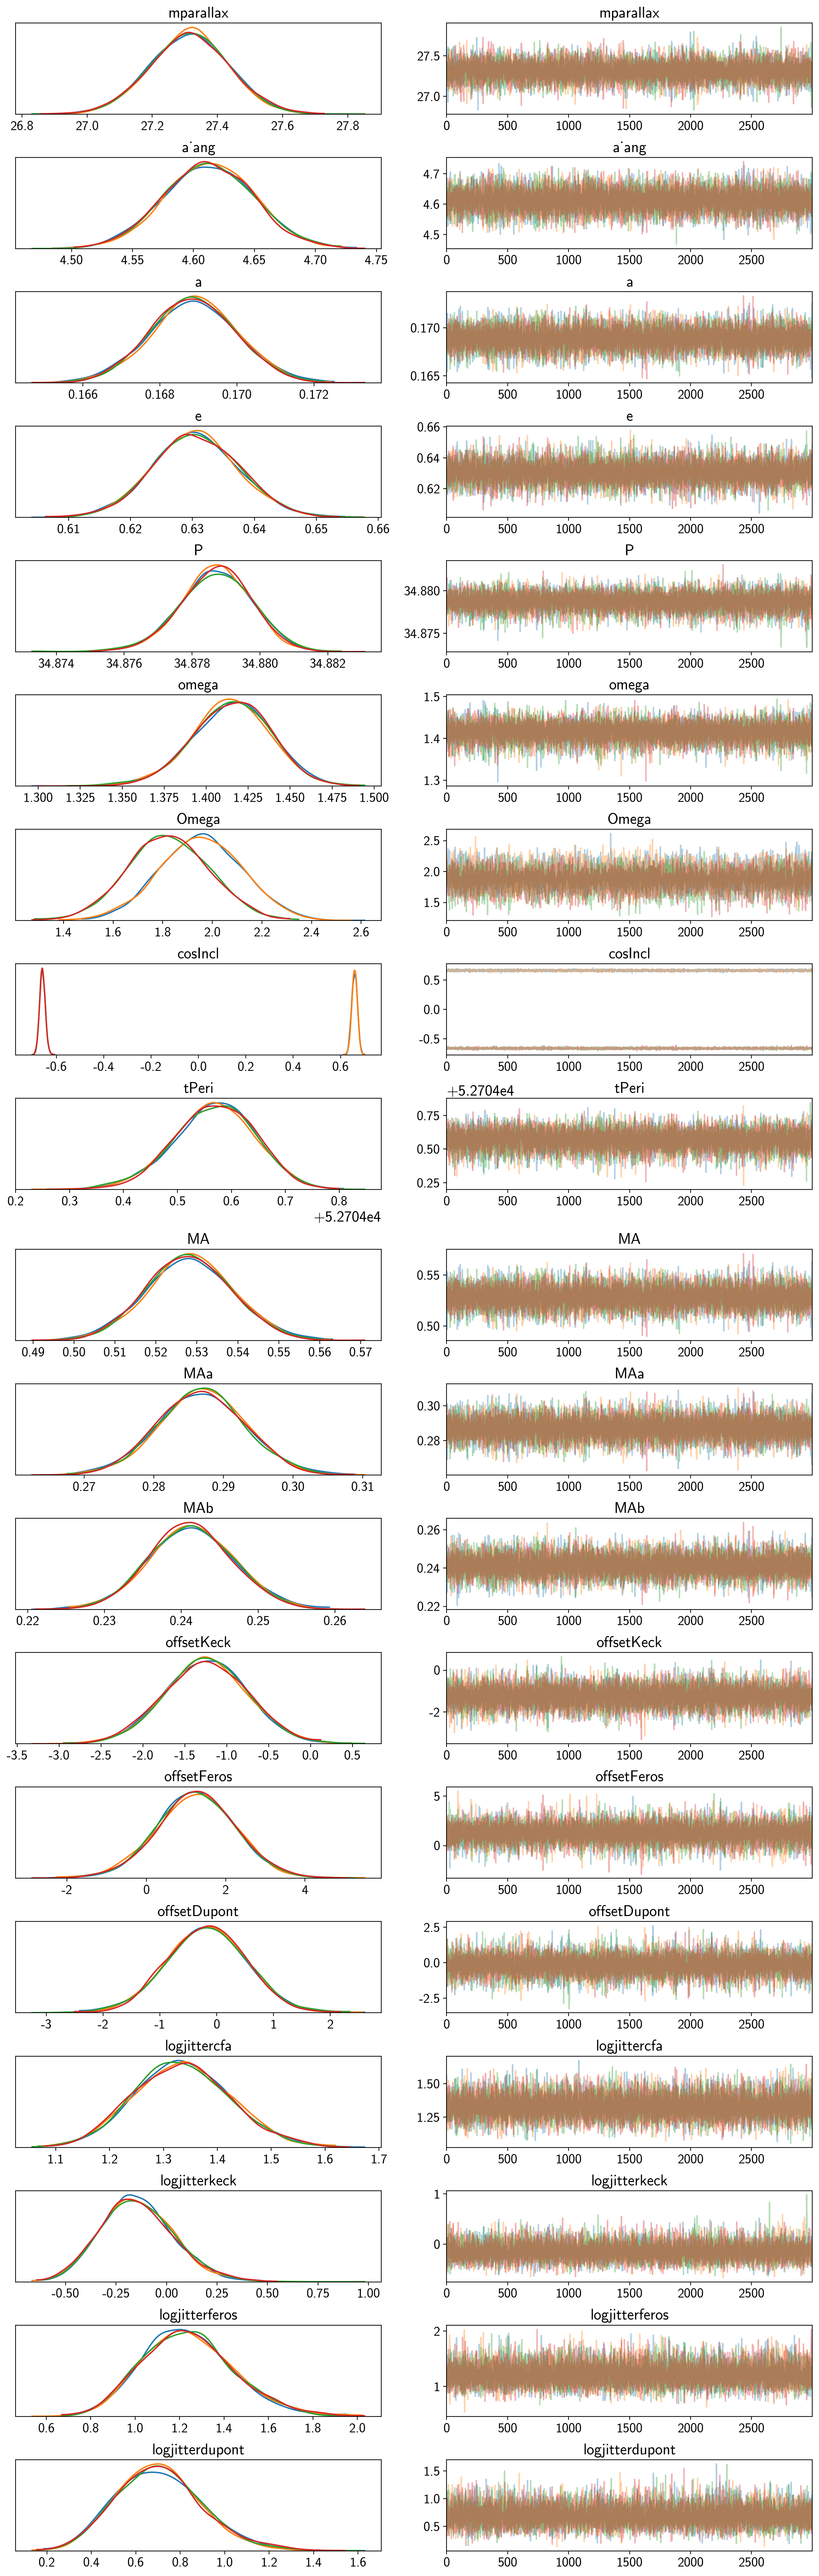

In [28]:
az.plot_trace(trace, var_names=["mparallax", "a_ang", "a", "e", "P", "omega", "Omega", "cosIncl", "tPeri", "MA", "MAa", "MAb",
                              "offsetKeck", "offsetFeros", "offsetDupont", 
                              "logjittercfa", "logjitterkeck", "logjitterferos", "logjitterdupont"])

To assess the quality of the fit, we should go and plot the fit and residuals for all of the data points individually and together.

The phase-folding plot only really works for a fixed value of `tperi`, `P`. So, we can plot the MAP phase fold. But other than that it only makes sense to plot the orbit scatter on the actual series of points (minus any offset, too). 

KeyError: 'RV1Dense'

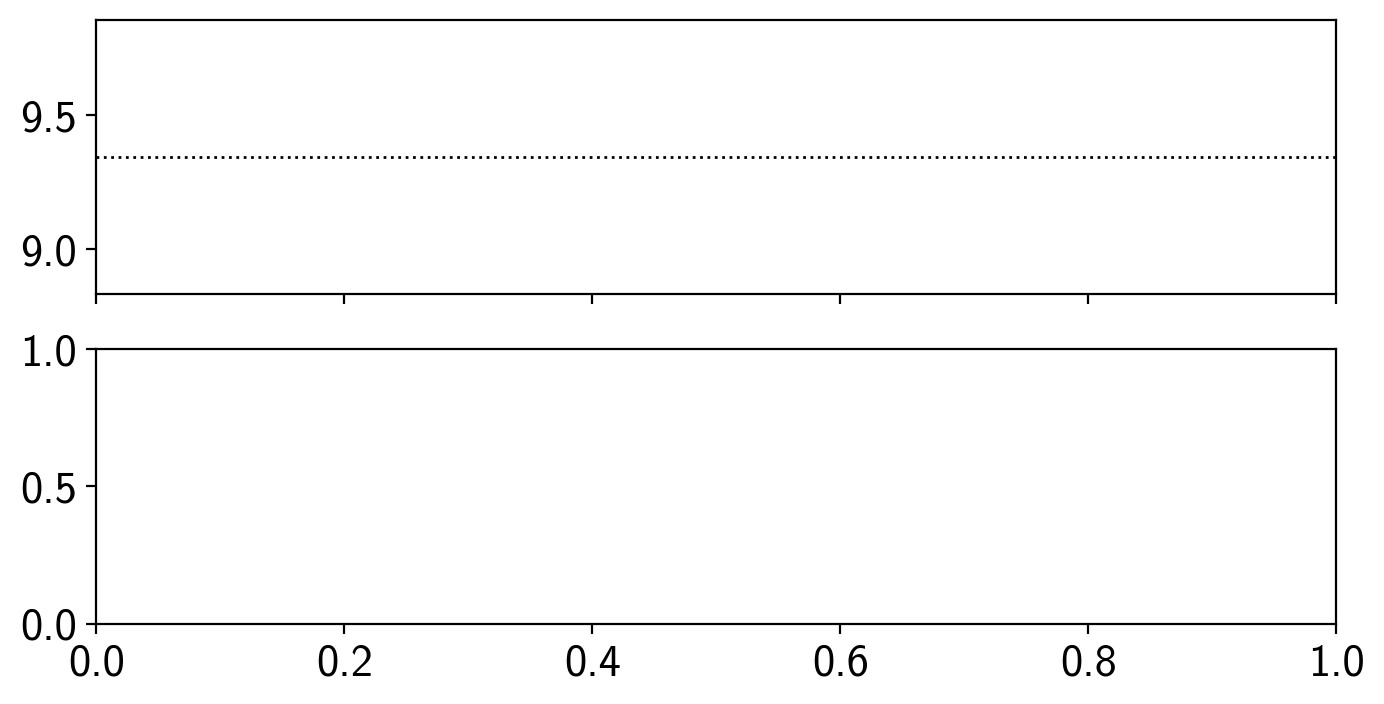

In [15]:
# plot everything ontop in a single plot

pkw = {"marker":".", "ls":""}
ekw = {"marker":".", "ms":5.0, "ls":"", "elinewidth":1.2}

def get_phase(dates, pos):
    return ((dates - pos["tPeri"]) % pos["P"]) / pos["P"]

# nsamples = 10
# choices = np.random.choice(np.arange(len(trace)), size=nsamples)

# just choose one representative sample
np.random.seed(43)
choice = np.random.choice(np.arange(len(trace)))

fig, ax = plt.subplots(nrows=2, sharex=True, figsize=(8,4))

with model:
    
    pos = trace[choice] 

    tperi = pos["tPeri"]
    P = pos["P"]

    # calculate the errors for each instrument
    cfa_err1 = np.sqrt(cfa1[2]**2 + np.exp(2 * pos["logjittercfa"]))
    cfa_err2 = np.sqrt(cfa2[2]**2 + np.exp(2 * pos["logjittercfa"]))
    
    keck_err1 = np.sqrt(keck1[2]**2 + np.exp(2 * pos["logjitterkeck"]))
    keck_err2 = np.sqrt(keck2[2]**2 + np.exp(2 * pos["logjitterkeck"]))
    
    feros_err1 = np.sqrt(feros1[2]**2 + np.exp(2 * pos["logjitterferos"]))
    feros_err2 = np.sqrt(feros2[2]**2 + np.exp(2 * pos["logjitterferos"]))
    
    dupont_err1 = np.sqrt(dupont1[2]**2 + np.exp(2 * pos["logjitterdupont"]))
    dupont_err2 = np.sqrt(dupont2[2]**2 + np.exp(2 * pos["logjitterdupont"]))
        
    # plot RV1 model
    ax[0].axhline(pos["gamma"], lw=1.0, color="k", ls=":")
    ax[0].plot(xs_phase, pos["RV1Dense"], zorder=-1)
    
    # at data locations
    ax[0].errorbar(get_phase(cfa1[0], pos), cfa1[1], yerr=cfa_err1, **ekw, zorder=0)
    ax[0].errorbar(get_phase(keck1[0], pos), keck1[1] - pos["offsetKeck"], yerr=keck_err1, **ekw, zorder=0)
    ax[0].errorbar(get_phase(feros1[0], pos), feros1[1] - pos["offsetFeros"], yerr=feros_err1, **ekw, zorder=0)
    ax[0].errorbar(get_phase(dupont1[0], pos), dupont1[1] - pos["offsetDupont"], yerr=dupont_err1, **ekw, zorder=0)
    
    # plot RV2
    ax[1].axhline(pos["gamma"], lw=1.0, color="k", ls=":")
    ax[1].plot(xs_phase, pos["RV2Dense"], zorder=-1)
    
    # at data locations
    ax[1].errorbar(get_phase(cfa2[0], pos), cfa2[1], yerr=cfa_err2, **ekw, zorder=0)
    ax[1].errorbar(get_phase(keck2[0], pos), keck2[1] - pos["offsetKeck"], yerr=keck_err2, **ekw, zorder=0)
    ax[1].errorbar(get_phase(feros2[0], pos), feros2[1] - pos["offsetFeros"], yerr=feros_err2, **ekw, zorder=0)
    ax[1].errorbar(get_phase(dupont2[0], pos), dupont2[1] - pos["offsetDupont"], yerr=dupont_err2, **ekw, zorder=0)

    ax[1].set_xlim(0.0, 1.0)
    ax[0].set_ylabel(r"$v_\mathrm{Aa}$ $[\mathrm{km s}^{-1}]$")
    ax[1].set_ylabel(r"$v_\mathrm{Ab}$ $[\mathrm{km s}^{-1}]$")
    ax[1].set_xlabel("phase")
    
fig.subplots_adjust(top=0.98, bottom=0.18, hspace=0.05)
fig.savefig("A_sb_orbit.pdf")

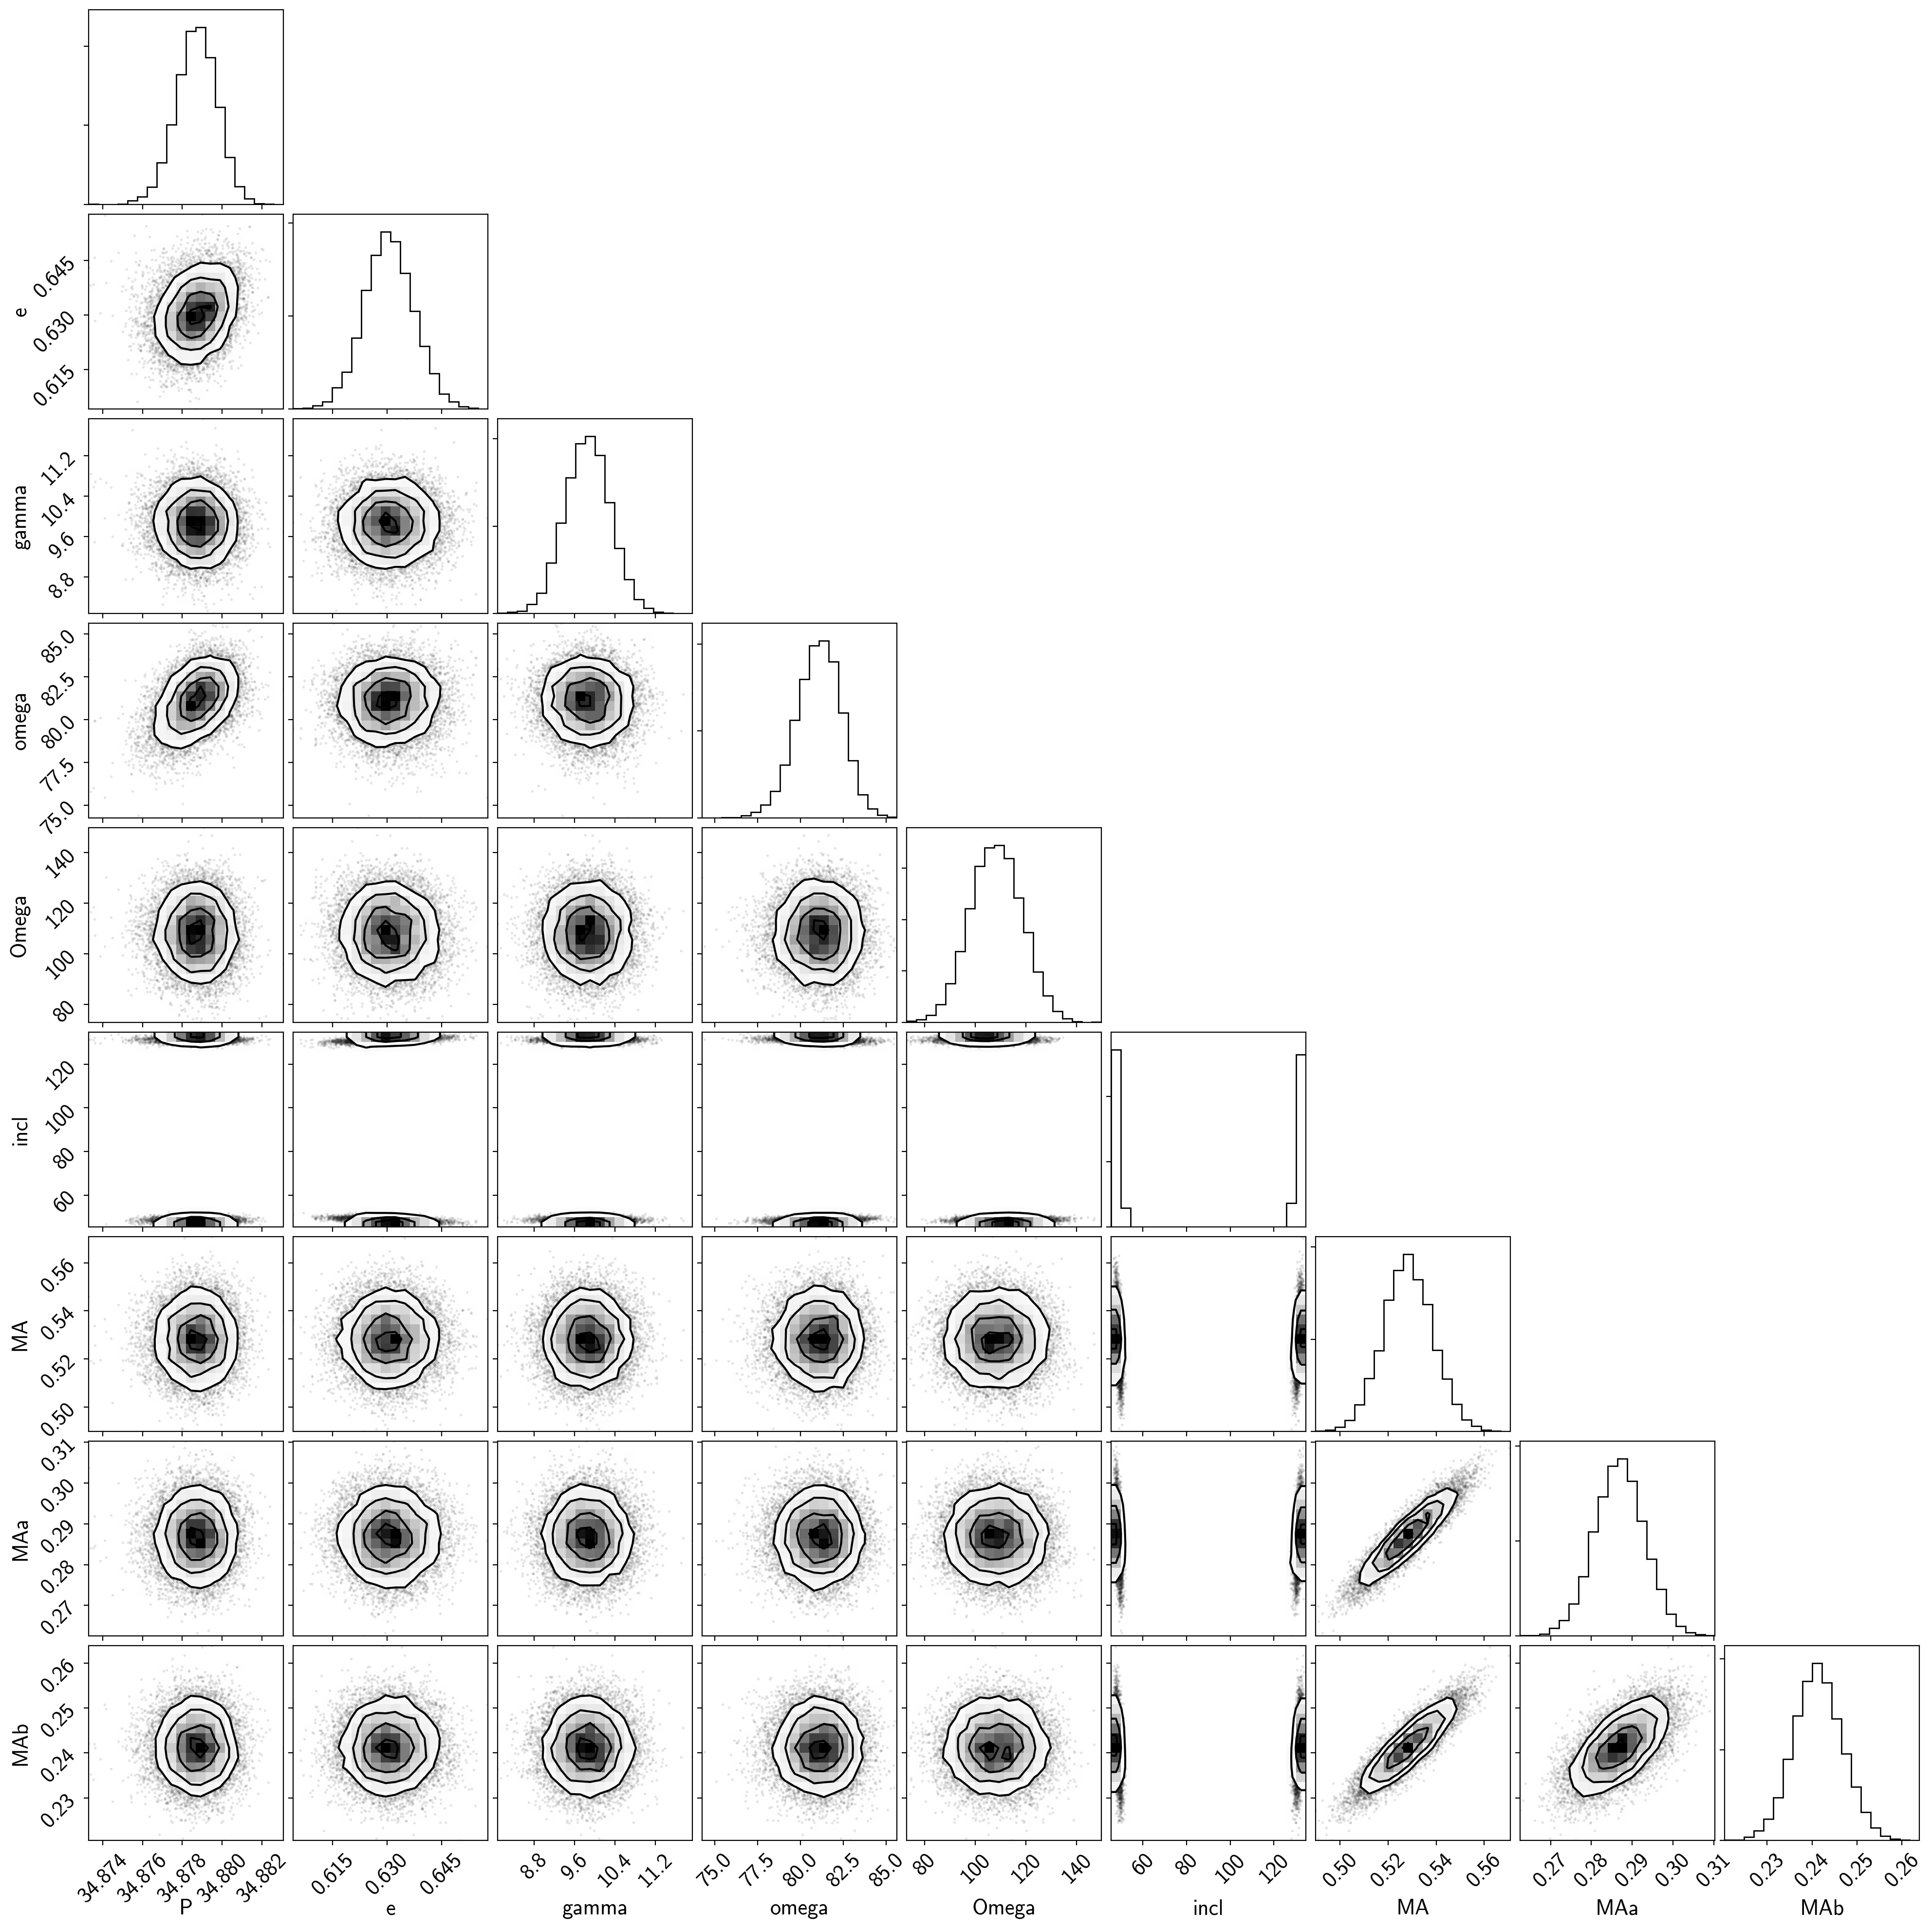

In [16]:
samples = pm.trace_to_dataframe(trace, varnames=["P", "e", "gamma", "omega", "Omega", "incl", 
                                                 "MA", "MAa", "MAb"])
samples["omega"] /= deg
samples["Omega"] /= deg
samples["incl"] /= deg
corner.corner(samples);

incl:48.75 +\- 0.89
Omega:112.10 +\- 9.46


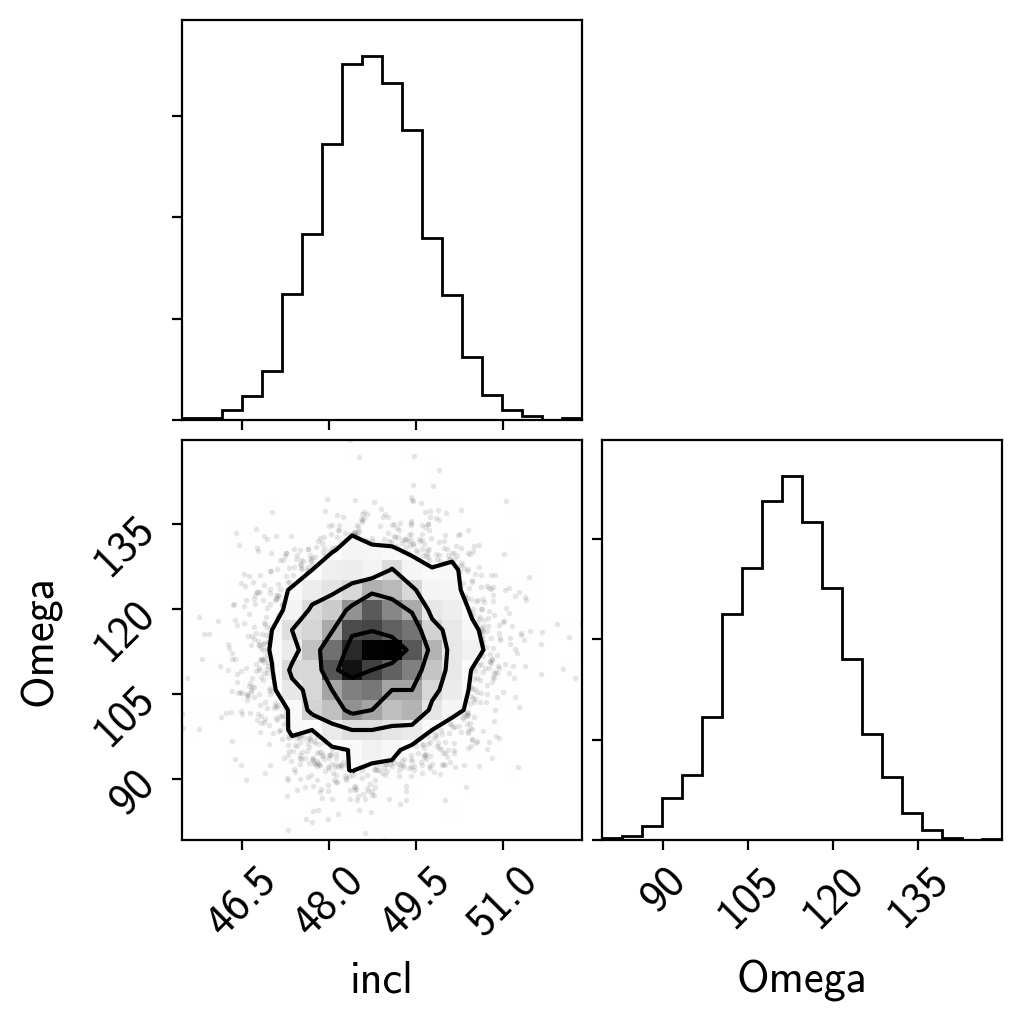

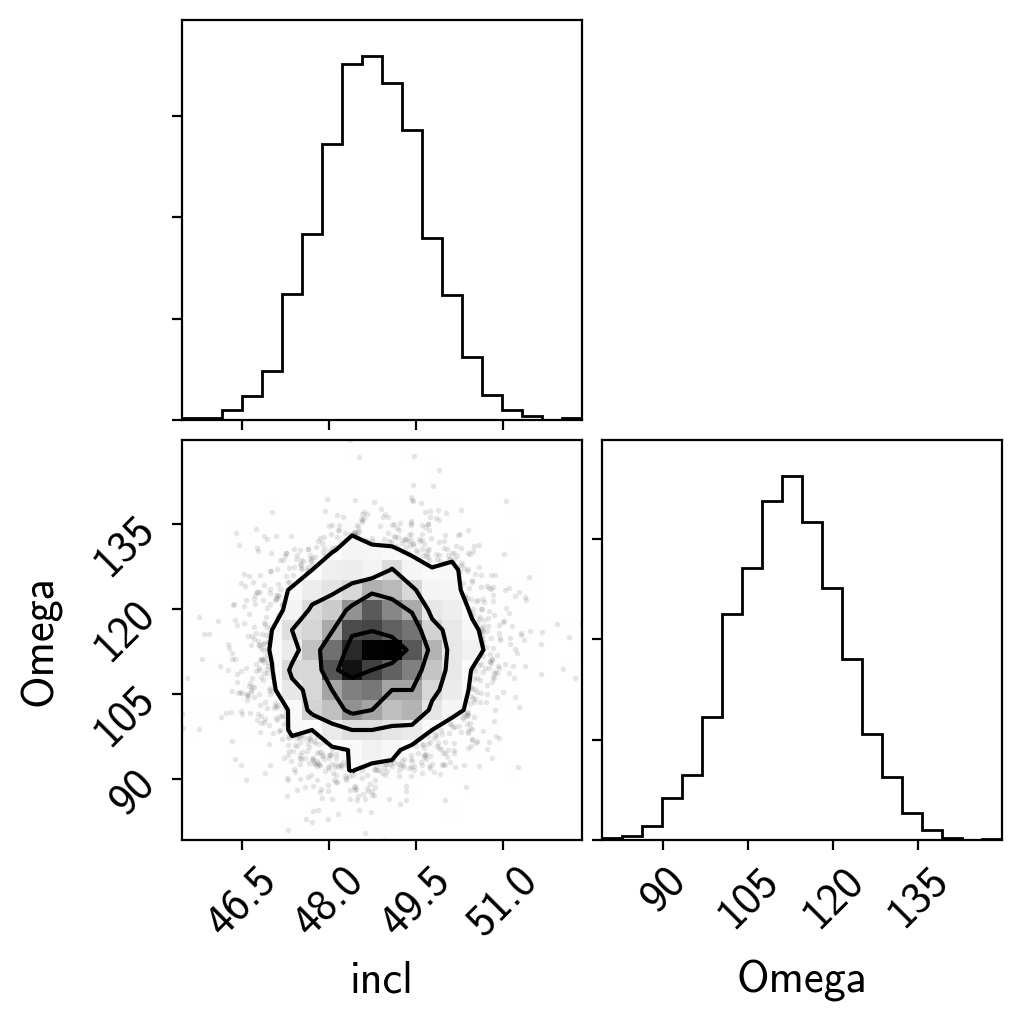

In [23]:
# split samples based on incl value, and plot the incl v. Omega plots
samples_ang = pm.trace_to_dataframe(trace, varnames=["incl", "Omega"])
samples_ang["incl"] /= deg
samples_ang["Omega"] /= deg

ind_below = samples_ang["incl"] < 90.0

print("incl:{:.2f} +\- {:.2f}".format(np.mean(samples_ang[ind_below]["incl"]), np.std(samples_ang[ind_below]["incl"])))
print("Omega:{:.2f} +\- {:.2f}".format(np.mean(samples_ang[ind_below]["Omega"]), np.std(samples_ang[ind_below]["Omega"])))

corner.corner(samples_ang[ind_below])

incl:131.25 +\- 0.90
Omega:104.44 +\- 9.41


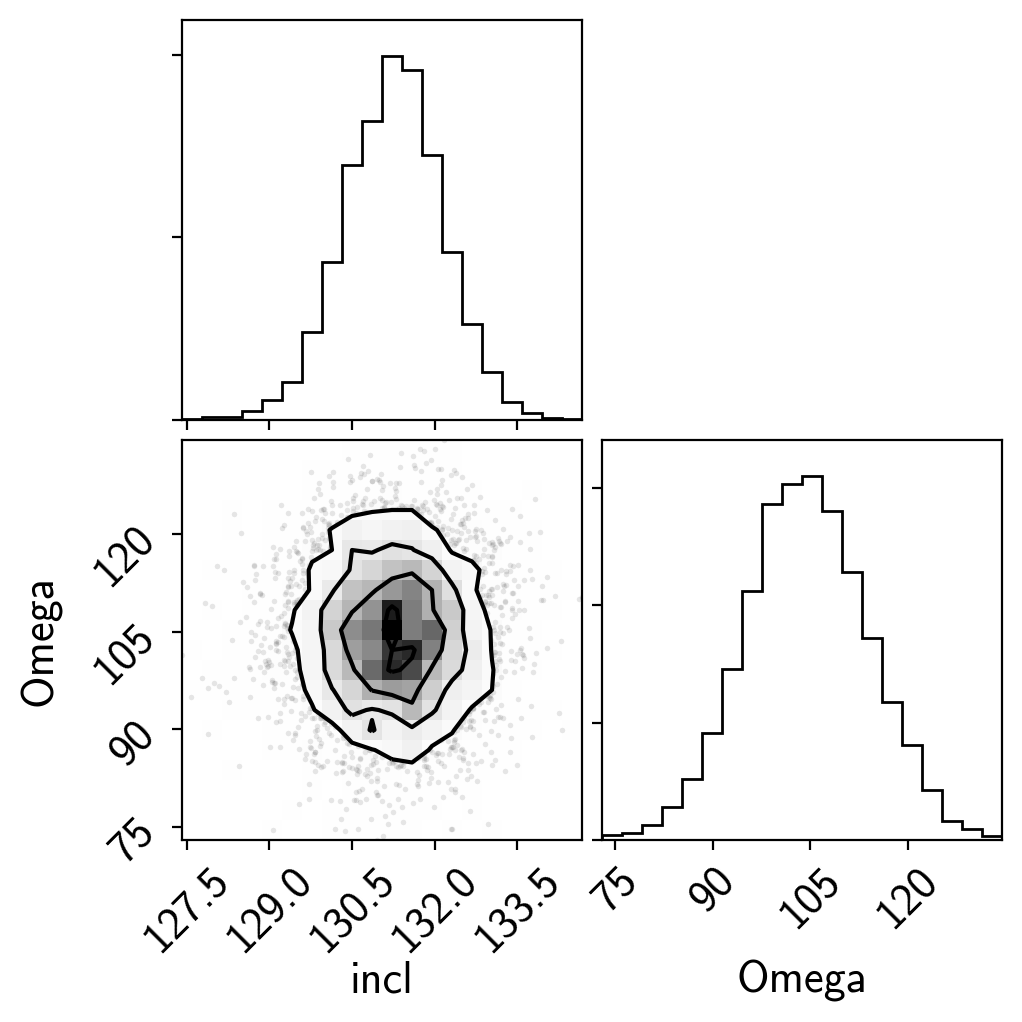

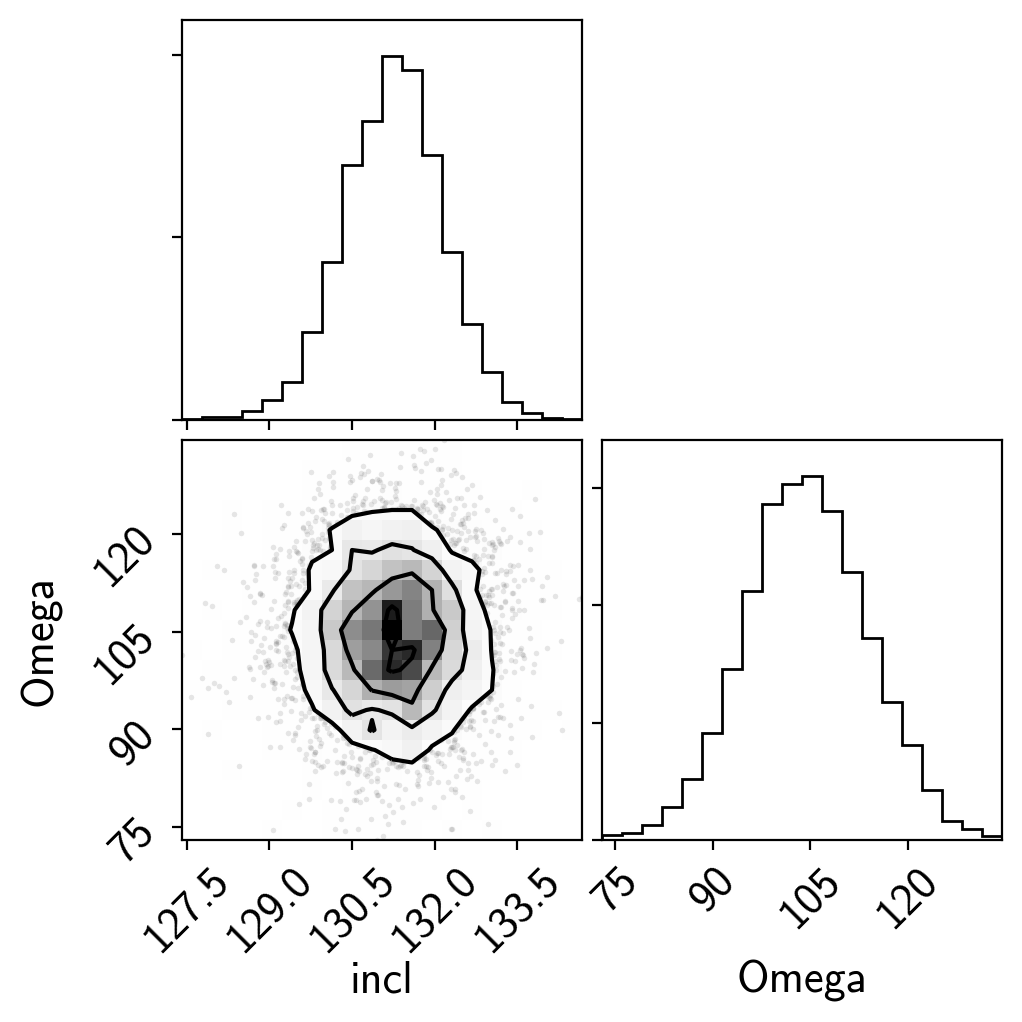

In [24]:
print("incl:{:.2f} +\- {:.2f}".format(np.mean(samples_ang[~ind_below]["incl"]), np.std(samples_ang[~ind_below]["incl"])))
print("Omega:{:.2f} +\- {:.2f}".format(np.mean(samples_ang[~ind_below]["Omega"]), np.std(samples_ang[~ind_below]["Omega"])))

corner.corner(samples_ang[~ind_below])

In [25]:
# save the samples to disk 
full_samples = pm.trace_to_dataframe(trace)
full_samples.to_csv("samples.csv")

Print a list of the best-fitting variables in the format of the hierarchical orbit to test

In [ ]:
# pick a sample at random 
full_samples.sample() # pandas random row

{par: row0[par].values[0] for par in sample_pars}

inner_vars = ["mparallax",
    "MAb",
    "a_ang_inner",
    "logP_inner",
    "e_inner",
    "omega_inner",
    "Omega_inner",
    "cos_incl_inner",
    "t_periastron_inner"]

In [26]:
full_samples.sample() # pandas random row

mparallax       MAb  offsetKeck  offsetFeros  offsetDupont  parallax  \
567  27.525997  0.234453   -2.087488    -0.190311     -1.073785  0.027526   

        a_ang         a      logP          P  ...       MA       MAa  \
567  4.615883  0.167692  3.551871  34.878503  ...  0.51715  0.282696   

     logjittercfa  logjitterkeck  logjitterferos  logjitterdupont   jitCfa  \
567      1.351571      -0.562375        1.006867         0.573101  3.86349   

      jitKeck  jitFeros  jitDupont  
567  0.569854  2.737013    1.77376  

[1 rows x 27 columns]

In [27]:
full_samples.sample().to_csv("test-sample.csv")